# **Proof of Concept**

In [245]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Device: {device}')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

Device: cuda
NVIDIA GeForce RTX 3050 Laptop GPU


In [246]:
# Definindo hiperparâmetros
batch_size = 16
epochs = 256

## **Processando os dados**

In [247]:
# Carregando os dados
data = pd.read_csv('features.csv')

# Separando os dados em X e y
X = data.drop('Classe', axis=1).values
y = data['Classe'].values

# Convertendo as labels para 0 e 1 com um dict
labels = {'Aleatória': 0, 'Humana': 1}
y = [labels[item] for item in y]

# Separando os dados em treino e teste -> 80% treino e 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

# Normalizando os dados
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Converter para tensores do PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

## **Rede Neural**

In [248]:
'''
Arquitetura para o teste:
X.shape[1] = 18 features x 32 (ReLU) x 32 (ReLU) x 1 (Sigmoid)

Batch size: 16
'''
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.layer1 = nn.Linear(X.shape[1], 32)
        self.relu = nn.ReLU()
        
        self.layer2 = nn.Linear(32, 32)
        
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.output(x))
        
        return x

## **Treinamento**

In [249]:
model = NeuralNetwork().to(device)

optimizer = torch.optim.Adam(model.parameters())
loss_function = nn.BCELoss()

for epoch in range(-1, epochs):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    # Calcular a média de perda da época
    epoch_loss /= len(train_loader)
    
    if (epoch+1) % (epochs/8) == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

Epoch 0/256, Loss: 0.6938
Epoch 32/256, Loss: 0.4408
Epoch 64/256, Loss: 0.4170
Epoch 96/256, Loss: 0.4063
Epoch 128/256, Loss: 0.3976
Epoch 160/256, Loss: 0.3900
Epoch 192/256, Loss: 0.3880
Epoch 224/256, Loss: 0.3873
Epoch 256/256, Loss: 0.3806


## **Teste**

In [250]:
# Avaliação
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_class = (y_pred > 0.5).cpu().int().numpy()  # Mover para CPU para usar com sklearn
    
    print()
    print(classification_report(y_test, y_pred_class))
    
    report = classification_report(y_test, y_pred_class, output_dict=True)


              precision    recall  f1-score   support

           0       0.78      0.73      0.76       109
           1       0.77      0.82      0.79       119

    accuracy                           0.78       228
   macro avg       0.78      0.77      0.78       228
weighted avg       0.78      0.78      0.78       228



In [251]:
# Salvando o modelo
torch.save(model.state_dict(), 'modelo.pt')

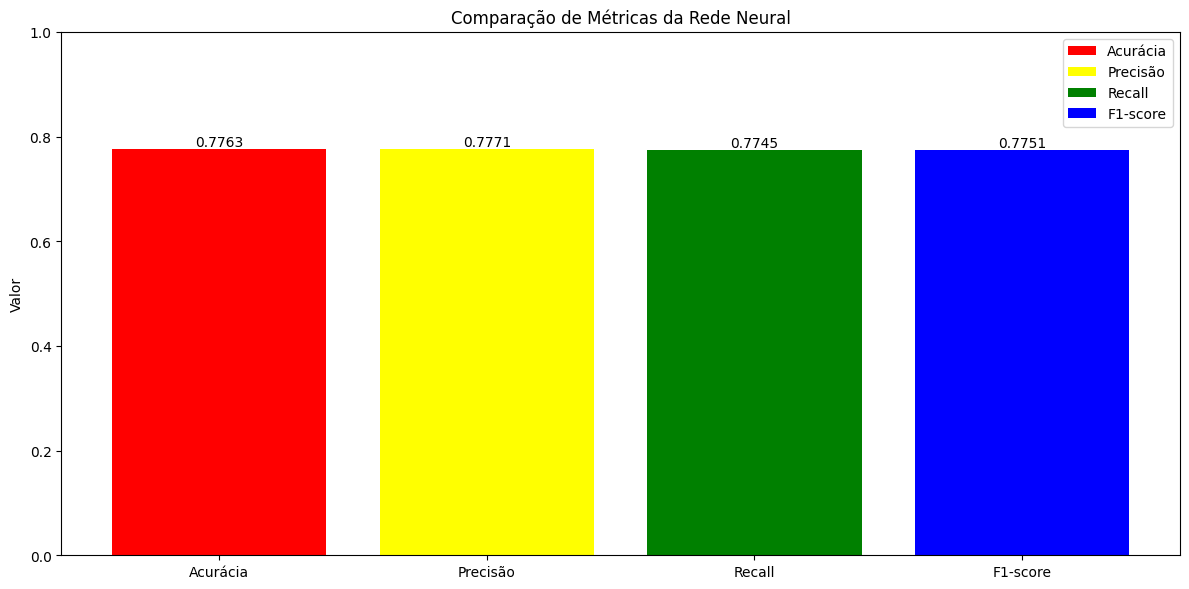

In [252]:
def metricas(modelo, report):
    accuracy = report['accuracy']
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1_score = report['macro avg']['f1-score']

    metricas = [accuracy, precision, recall, f1_score]
    rotulos = ['Acurácia', 'Precisão', 'Recall', 'F1-score']
    cores = ['red', 'yellow', 'green', 'blue']

    plt.figure(figsize=(12, 6))

    for i in range(len(metricas)):
        plt.bar(i, metricas[i], label=rotulos[i], color=cores[i])

        # Adicionar o valor acima de cada barra
        plt.text(i, metricas[i], f'{metricas[i]:.4f}', ha='center', va='bottom')

    plt.ylim(0, 1.0)
    plt.xticks(range(len(metricas)), rotulos)
    plt.ylabel('Valor')
    plt.title(f'Comparação de Métricas da {modelo}')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    
metricas('Rede Neural', report)

# **Hiperparâmetros**

## **Afunilando epochs**

batch_size = 16

In [259]:
# Fixando o batch_size em 16
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

In [260]:
import numpy as np

epochs = np.linspace(256, 512, 5, dtype=int)

reports = {}
losses = {}
num_runs = 5  # Número de execuções por época

for epoch in epochs:
    run_losses = []
    metrics = {'precision': [], 'recall': [], 'f1-score': [], 'accuracy': []}

    for run in range(num_runs):
        print(f'Epochs: {epoch}, Run: {run+1}')
        
        model = NeuralNetwork().to(device)
        
        # Otimizador e função de perda
        optimizer = torch.optim.Adam(model.parameters())
        loss_function = nn.BCELoss()
        
        # Treinamento
        for e in range(epoch):
            epoch_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()

                y_pred = model(X_batch)

                loss = loss_function(y_pred, y_batch)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            # Calcular a média de perda da época
            epoch_loss /= len(train_loader)

        run_losses.append(epoch_loss)
        
        # Avaliação
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor)
            y_pred_class = (y_pred > 0.5).cpu().int().numpy()
            report = classification_report(y_test, y_pred_class, output_dict=True)
            
            metrics['precision'].append(report['weighted avg']['precision'])
            metrics['recall'].append(report['weighted avg']['recall'])
            metrics['f1-score'].append(report['weighted avg']['f1-score'])
            metrics['accuracy'].append(report['accuracy'])
    
    print()
    # Calcular a média das métricas após todas as execuções
    losses[epoch] = np.mean(run_losses)
    reports[epoch] = {metric: np.mean(values) for metric, values in metrics.items()}

Epochs: 256, Run: 1
Epochs: 256, Run: 2
Epochs: 256, Run: 3
Epochs: 256, Run: 4
Epochs: 256, Run: 5

Epochs: 320, Run: 1
Epochs: 320, Run: 2
Epochs: 320, Run: 3
Epochs: 320, Run: 4
Epochs: 320, Run: 5

Epochs: 384, Run: 1
Epochs: 384, Run: 2
Epochs: 384, Run: 3
Epochs: 384, Run: 4
Epochs: 384, Run: 5

Epochs: 448, Run: 1
Epochs: 448, Run: 2
Epochs: 448, Run: 3
Epochs: 448, Run: 4
Epochs: 448, Run: 5

Epochs: 512, Run: 1
Epochs: 512, Run: 2
Epochs: 512, Run: 3
Epochs: 512, Run: 4
Epochs: 512, Run: 5



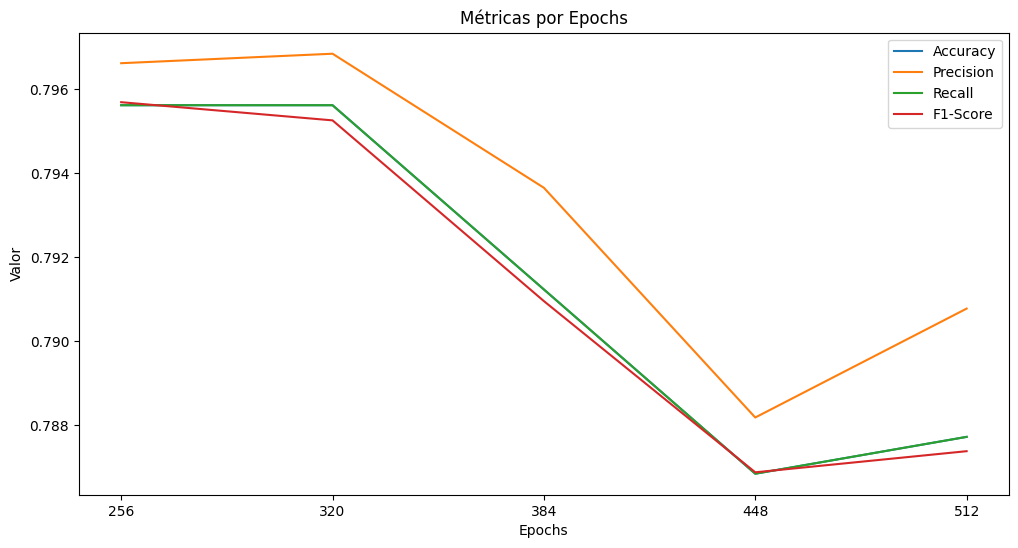

In [261]:
import matplotlib.pyplot as plt

epochs = sorted(reports.keys())

accuracy = []
precision = []
recall = []
f1 = []

for epoch in epochs:
    accuracy.append(reports[epoch]['accuracy'])
    precision.append(reports[epoch]['precision'])
    recall.append(reports[epoch]['recall'])
    f1.append(reports[epoch]['f1-score'])

plt.figure(figsize=(12, 6))

plt.plot(epochs, accuracy, label='Accuracy')
plt.plot(epochs, precision, label='Precision')
plt.plot(epochs, recall, label='Recall')
plt.plot(epochs, f1, label='F1-Score')

plt.title('Métricas por Epochs')
plt.xlabel('Epochs')
plt.ylabel('Valor')

plt.xticks(epochs)
plt.legend()
plt.show()